In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   

In [43]:
app_att = pd.read_csv("../data_source/apartment_attributes.csv")
user_viewings = pd.read_csv("../data_source/user_viewings.csv")
app = pd.read_csv("../data_source/apartment.csv")
booking = pd.read_csv("../data_source/booking.csv")

In [44]:
app_att.head()

,id,category,body,amenities,bathrooms,bedrooms,fee,has_photo,pets_allowed,price_display,price_type,square_feet,address,cityname,state,latitude,longitude
0,1,2BHK,Happy product model process necessary. Only fo...,"Balcony, Air Conditioning",1,1,168.84,True,False,$1588.42,Monthly,1463,"92525 Holt Turnpike Lake Keith, KY 50153",New York,California,20.457092,0.466220
1,2,Penthouse,Technology past much. Shoulder collection appr...,"Garden, Pet-friendly, Balcony",2,2,202.99,False,True,$3585.32,Yearly,722,"89610 Chang Lane Apt. 295 New Ericaland, NC 28192",Austin,Texas,38.182993,-129.769256
2,3,3BHK,Firm agreement shake design sort. Size source ...,Gym,2,1,488.93,False,False,$1961.69,Monthly,2208,"134 Bryan Island Leefort, VT 48142",Chicago,Illinois,61.585391,-92.597924
3,4,1BHK,Next may hear camera. Heart dinner onto increa...,Garden,3,3,376.10,True,False,$4845.75,Yearly,589,"13660 Amanda Isle East Michaelchester, CT 62513",San Antonio,Texas,-59.015450,6.296552
4,5,1BHK,Space necessary each statement sport early. Fi...,Pet-friendly,2,2,465.79,False,True,$2599.65,One-time,1590,"7915 Laurie Manor Port John, MN 73309",Los Angeles,California,-48.009442,-33.172952


In [45]:
app.head()

,id,title,source,price,currency,listing_created_on,is_active,last_modified_timestamp
0,1,"Johnson, Fowler and Johnson",Realtor,4020.95,EUR,2024-03-27,True,2021-12-27
1,2,Kelley-Johnson,Craigslist,1390.01,INR,2023-07-23,True,2023-02-10
2,3,"Gibson, Delgado and Austin",Craigslist,3082.67,INR,2024-04-15,True,2020-01-02
3,4,"Kelly, Smith and Gibson",Zillow,4724.20,USD,2020-10-27,False,2023-06-23
4,5,Carroll-Burch,Airbnb,3867.11,USD,2021-02-01,False,2022-07-25


In [46]:
apartments = app.merge(app_att, on='id')

In [47]:
apartments.head()

,id,title,source,price,currency,listing_created_on,is_active,last_modified_timestamp,category,body,...,has_photo,pets_allowed,price_display,price_type,square_feet,address,cityname,state,latitude,longitude
0,1,"Johnson, Fowler and Johnson",Realtor,4020.95,EUR,2024-03-27,True,2021-12-27,2BHK,Happy product model process necessary. Only fo...,...,True,False,$1588.42,Monthly,1463,"92525 Holt Turnpike Lake Keith, KY 50153",New York,California,20.457092,0.466220
1,2,Kelley-Johnson,Craigslist,1390.01,INR,2023-07-23,True,2023-02-10,Penthouse,Technology past much. Shoulder collection appr...,...,False,True,$3585.32,Yearly,722,"89610 Chang Lane Apt. 295 New Ericaland, NC 28192",Austin,Texas,38.182993,-129.769256
2,3,"Gibson, Delgado and Austin",Craigslist,3082.67,INR,2024-04-15,True,2020-01-02,3BHK,Firm agreement shake design sort. Size source ...,...,False,False,$1961.69,Monthly,2208,"134 Bryan Island Leefort, VT 48142",Chicago,Illinois,61.585391,-92.597924
3,4,"Kelly, Smith and Gibson",Zillow,4724.20,USD,2020-10-27,False,2023-06-23,1BHK,Next may hear camera. Heart dinner onto increa...,...,True,False,$4845.75,Yearly,589,"13660 Amanda Isle East Michaelchester, CT 62513",San Antonio,Texas,-59.015450,6.296552
4,5,Carroll-Burch,Airbnb,3867.11,USD,2021-02-01,False,2022-07-25,1BHK,Space necessary each statement sport early. Fi...,...,False,True,$2599.65,One-time,1590,"7915 Laurie Manor Port John, MN 73309",Los Angeles,California,-48.009442,-33.172952


In [48]:
apartments.isnull().sum()

id                              0
title                           0
source                          0
price                           0
currency                        0
listing_created_on              0
is_active                       0
last_modified_timestamp         0
category                        0
body                            0
amenities                       0
bathrooms                       0
bedrooms                        0
fee                             0
has_photo                       0
pets_allowed               129044
price_display                   0
price_type                      0
square_feet                     0
address                         0
cityname                        0
state                           0
latitude                        0
longitude                       0
dtype: int64

In [49]:
apartments.columns

Index(['id', 'title', 'source', 'price', 'currency', 'listing_created_on',
       'is_active', 'last_modified_timestamp', 'category', 'body', 'amenities',
       'bathrooms', 'bedrooms', 'fee', 'has_photo', 'pets_allowed',
       'price_display', 'price_type', 'square_feet', 'address', 'cityname',
       'state', 'latitude', 'longitude'],
      dtype='object')

In [ ]:
#  Average Listing Price: Compute the average price of active rental listings each week.
active_apartments = apartments[apartments['is_active'] == True]
active_apartments['listing_created_on'] = pd.to_datetime(active_apartments['listing_created_on'])
active_apartments['week_start'] = active_apartments['listing_created_on'].dt.to_period('W').apply(lambda r: r.start_time)
avg_listing_price_per_week = active_apartments.groupby('week_start').agg(avg_listing_price=('price', 'mean')).reset_index()
avg_listing_price_per_week.head()

C:\Users\HeskeyAmoakoFordjour\AppData\Local\Temp\ipykernel_20280\59060950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_apartments['listing_created_on'] = pd.to_datetime(active_apartments['listing_created_on'])
C:\Users\HeskeyAmoakoFordjour\AppData\Local\Temp\ipykernel_20280\59060950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_apartments['week_start'] = active_apartments['listing_created_on'].dt.to_period('W').apply(lambda r: r.start_time)


,week_start,avg_listing_price
0,2019-12-30,3069.052797
1,2020-01-06,2978.171657
2,2020-01-13,2988.534457
3,2020-01-20,3162.005817
4,2020-01-27,2881.686546


In [62]:
avg_listing_price_per_week.shape

(274, 2)

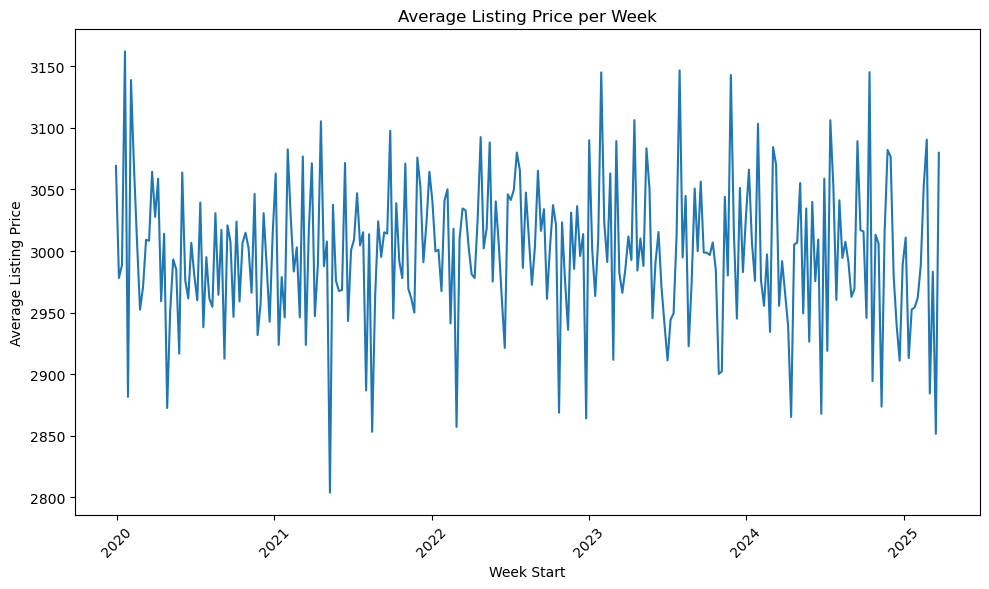

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(avg_listing_price_per_week['week_start'], avg_listing_price_per_week['avg_listing_price'])
plt.xlabel('Week Start')
plt.ylabel('Average Listing Price')
plt.title('Average Listing Price per Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [54]:
#  Occupancy Rate: Measure the percentage of available rental nights that were booked over a month.
booking['checkin_date'] = pd.to_datetime(booking['checkin_date'])
booking['checkout_date'] = pd.to_datetime(booking['checkout_date'])
booking['booked_nights'] = (booking['checkout_date'] - booking['checkin_date']).dt.days
# Filter for confirmed bookings only (assuming booking_status column has 'confirmed')
confirmed_bookings = booking[booking['booking_status'] == 'confirmed']
confirmed_bookings['month'] = confirmed_bookings['checkin_date'].dt.to_period('M').apply(lambda r: r.start_time)
total_booked_nights = confirmed_bookings.groupby('month').agg(total_booked_nights=('booked_nights', 'sum')).reset_index()
# Get active apartments count
active_apartments = app[app['is_active'] == True]
active_apartment_count = len(active_apartments)

# Create a dataframe for each month with total available nights
available_nights = total_booked_nights[['month']].copy()
available_nights['days_in_month'] = available_nights['month'].dt.daysinmonth
available_nights['total_available_nights'] = available_nights['days_in_month'] * active_apartment_count

# Merge and calculate occupancy rate
occupancy_df = total_booked_nights.merge(available_nights, on='month')
occupancy_df['occupancy_rate'] = (occupancy_df['total_booked_nights'] / occupancy_df['total_available_nights']) * 100
occupancy_df.head()


C:\Users\HeskeyAmoakoFordjour\AppData\Local\Temp\ipykernel_20280\3861384404.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_bookings['month'] = confirmed_bookings['checkin_date'].dt.to_period('M').apply(lambda r: r.start_time)


,month,total_booked_nights,days_in_month,total_available_nights,occupancy_rate
0,2020-01-01,2497828,31,3106293,80.411861
1,2020-02-01,2337624,29,2905887,80.444422
2,2020-03-01,2429867,31,3106293,78.224012
3,2020-04-01,2261830,30,3006090,75.241593
4,2020-05-01,2280921,31,3106293,73.429036


In [55]:
occupancy_df.shape

(63, 5)

In [56]:
occupancy_df.tail()

,month,total_booked_nights,days_in_month,total_available_nights,occupancy_rate
58,2024-11-01,-2193535,30,3006090,-72.969705
59,2024-12-01,-2247027,31,3106293,-72.337896
60,2025-01-01,-2379701,31,3106293,-76.609032
61,2025-02-01,-2222767,28,2805684,-79.223712
62,2025-03-01,-1950685,31,3106293,-62.797843


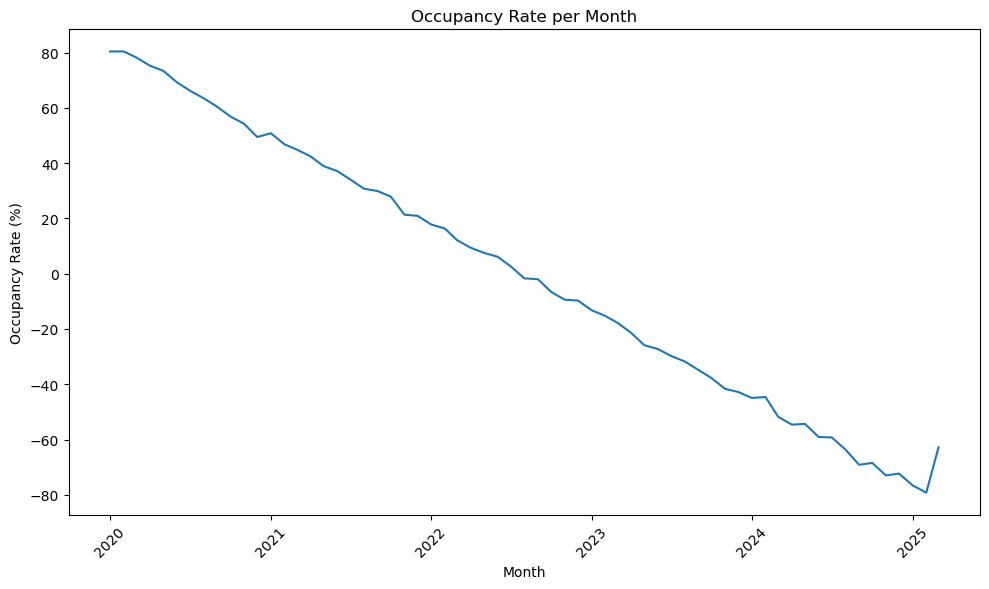

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(occupancy_df['month'], occupancy_df['occupancy_rate'])
plt.xlabel('Month')
plt.ylabel('Occupancy Rate (%)')
plt.title('Occupancy Rate per Month')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

In [61]:
# Most Popular Locations: Identify the most frequently booked cities every week.
bookings_merged = booking.merge(app_att[['id', 'cityname']], left_on='apartment_id', right_on='id', how='left')
bookings_merged['booking_date'] = pd.to_datetime(bookings_merged['booking_date'])
bookings_merged['week'] = bookings_merged['booking_date'].dt.to_period('W').apply(lambda r: r.start_time)
city_bookings_per_week = bookings_merged.groupby(['week', 'cityname']).size().reset_index(name='total_bookings')
most_popular_cities = city_bookings_per_week.loc[
    city_bookings_per_week.groupby('week')['total_bookings'].idxmax()
].reset_index(drop=True)
most_popular_cities.head()

,week,cityname,total_bookings
0,2019-12-30,Phoenix,141
1,2020-01-06,Philadelphia,201
2,2020-01-13,Dallas,217
3,2020-01-20,Dallas,221
4,2020-01-27,Chicago,218


In [63]:
most_popular_cities.shape

(274, 3)

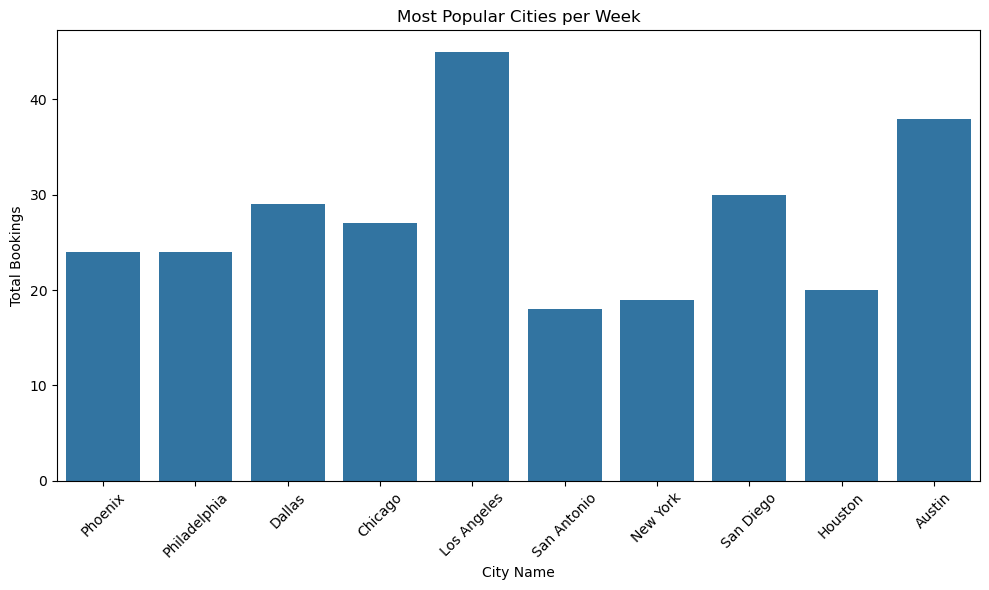

In [73]:
plt.figure(figsize=(10, 6))
sns.countplot(data=most_popular_cities, x='cityname')
plt.xlabel('City Name')
plt.ylabel('Total Bookings')
plt.title('Most Popular Cities per Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [75]:
# Top Performing Listings: Track properties with the highest confirmed revenue per week.
confirmed_bookings = booking[booking['booking_status'] == 'confirmed']
confirmed_bookings['booking_date'] = pd.to_datetime(confirmed_bookings['booking_date'])
confirmed_bookings['week'] = confirmed_bookings['booking_date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_revenue = confirmed_bookings.groupby(['week', 'apartment_id'])['total_price'].sum().reset_index()
weekly_revenue.rename(columns={'total_price': 'total_revenue'}, inplace=True)
top_performing_listings = weekly_revenue.loc[
    weekly_revenue.groupby('week')['total_revenue'].idxmax()
].reset_index(drop=True)
top_performing_listings.head()


C:\Users\HeskeyAmoakoFordjour\AppData\Local\Temp\ipykernel_20280\805193225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_bookings['booking_date'] = pd.to_datetime(confirmed_bookings['booking_date'])
C:\Users\HeskeyAmoakoFordjour\AppData\Local\Temp\ipykernel_20280\805193225.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_bookings['week'] = confirmed_bookings['booking_date'].dt.to_period('W').apply(lambda r: r.start_time)


,week,apartment_id,total_revenue
0,2019-12-30,77201,4975.47
1,2020-01-06,117340,4989.89
2,2020-01-13,19232,5244.40
3,2020-01-20,73567,4991.30
4,2020-01-27,13245,4992.82


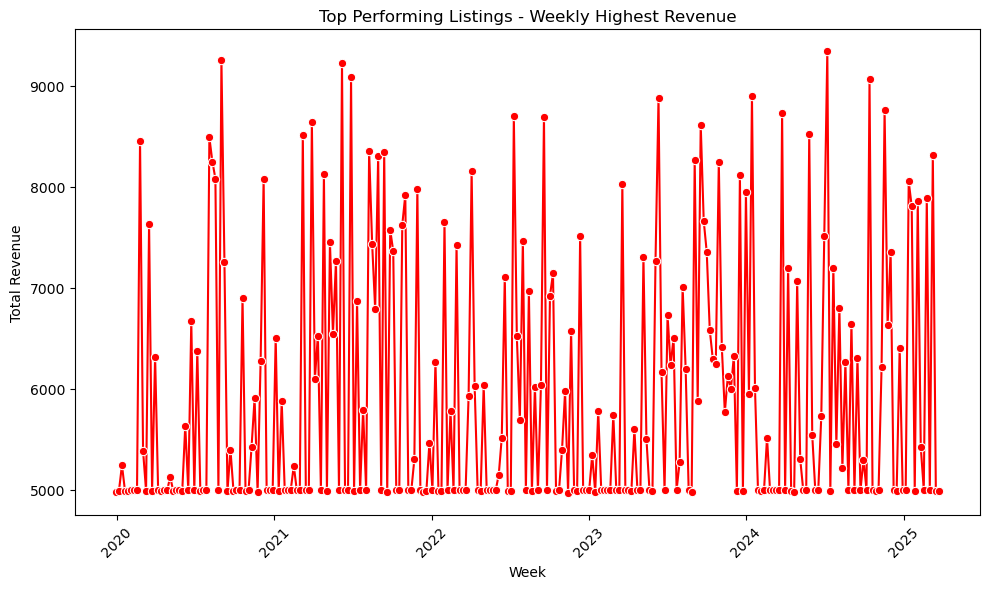

In [78]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=top_performing_listings, x="week", y="total_revenue", marker="o", color="red")
plt.xlabel('Week')
plt.ylabel('Total Revenue')
plt.title('Top Performing Listings - Weekly Highest Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [80]:
# Total Booking per User
confirmed = booking[booking['booking_status'] == 'confirmed']
confirmed['booking_date'] = pd.to_datetime(confirmed['booking_date'])
confirmed['week'] = confirmed['booking_date'].dt.to_period('W').apply(lambda r: r.start_time)

total_bookings_per_user = confirmed.groupby(['week', 'user_id']).size().reset_index(name='total_bookings')
total_bookings_per_user.head()


C:\Users\HeskeyAmoakoFordjour\AppData\Local\Temp\ipykernel_20280\2067007702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed['booking_date'] = pd.to_datetime(confirmed['booking_date'])
C:\Users\HeskeyAmoakoFordjour\AppData\Local\Temp\ipykernel_20280\2067007702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed['week'] = confirmed['booking_date'].dt.to_period('W').apply(lambda r: r.start_time)


,week,user_id,total_bookings
0,2019-12-30,13,1
1,2019-12-30,39,1
2,2019-12-30,49,1
3,2019-12-30,55,1
4,2019-12-30,61,1


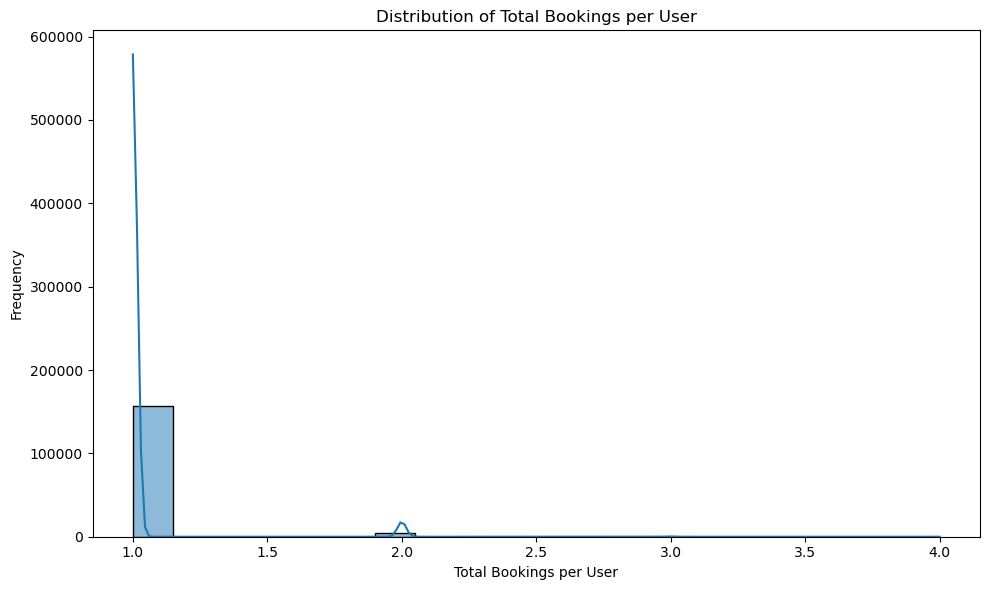

In [82]:
plt.figure(figsize=(10, 6))
sns.histplot(total_bookings_per_user['total_bookings'], kde=True, bins=20)
plt.xlabel('Total Bookings per User')
plt.ylabel('Frequency')
plt.title('Distribution of Total Bookings per User')
plt.tight_layout()
plt.show()

In [84]:
# Convert checkin and checkout dates to datetime if not already done
confirmed['checkin_date'] = pd.to_datetime(confirmed['checkin_date'])
confirmed['checkout_date'] = pd.to_datetime(confirmed['checkout_date'])
confirmed['duration'] = (confirmed['checkout_date'] - confirmed['checkin_date']).dt.days

# Create a month column from checkin_date
confirmed['month'] = confirmed['checkin_date'].dt.to_period('M').apply(lambda r: r.start_time)

# Group by month and calculate average booking duration
avg_duration_per_month = confirmed.groupby('month')['duration'].mean().reset_index(name='avg_booking_duration')
avg_duration_per_month.head()

C:\Users\HeskeyAmoakoFordjour\AppData\Local\Temp\ipykernel_20280\2554878276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed['checkin_date'] = pd.to_datetime(confirmed['checkin_date'])
C:\Users\HeskeyAmoakoFordjour\AppData\Local\Temp\ipykernel_20280\2554878276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed['checkout_date'] = pd.to_datetime(confirmed['checkout_date'])
C:\Users\HeskeyAmoakoFordjour\AppData\Local\Temp\ipykernel_20280\2554878276.py:4: SettingWithCopyWarning: 
A value

,month,avg_booking_duration
0,2020-01-01,932.373274
1,2020-02-01,917.434851
2,2020-03-01,893.005145
3,2020-04-01,846.176581
4,2020-05-01,821.953514


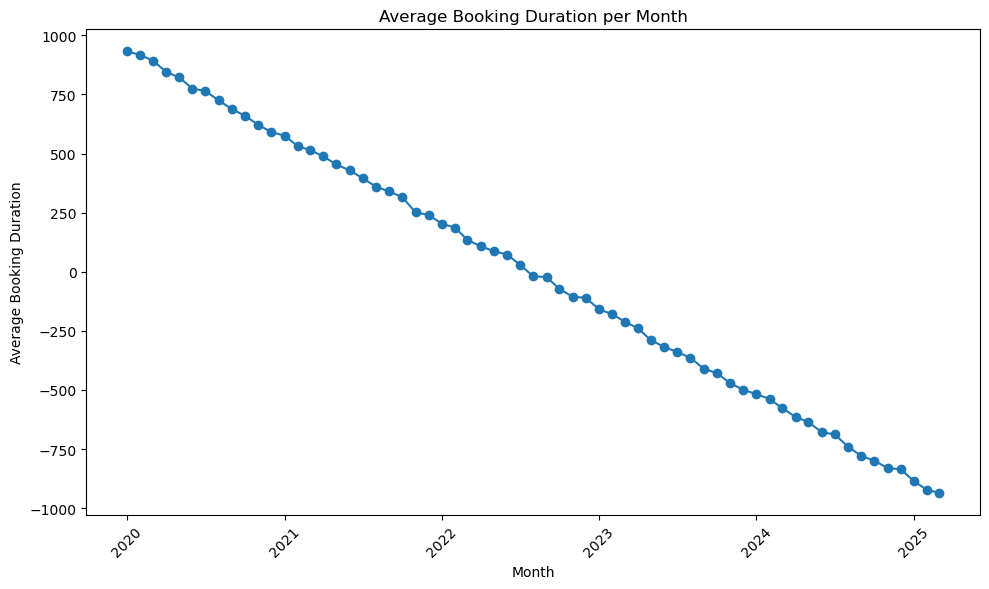

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(avg_duration_per_month['month'], avg_duration_per_month['avg_booking_duration'], marker='o')
plt.xlabel('Month')
plt.ylabel('Average Booking Duration')
plt.title('Average Booking Duration per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [100]:
confirmed = confirmed.sort_values(by=['user_id', 'booking_date'])
confirmed = confirmed.groupby('user_id', group_keys=False).apply(
    lambda grp: grp.assign(rolling_count=grp.rolling('30D', on='booking_date')['booking_date'].count())
)


# Count users with rolling_count > 1
confirmed['repeat_user'] = confirmed['rolling_count'] > 1
repeat_customer_rate = confirmed.groupby(confirmed['booking_date'].dt.to_period('M')).agg(
    total_users=('user_id', 'nunique'),
    repeat_users=('repeat_user', 'sum')
).reset_index()

repeat_customer_rate['repeat_customer_rate'] = (repeat_customer_rate['repeat_users'] / repeat_customer_rate['total_users']) * 100
repeat_customer_rate.head()


C:\Users\HeskeyAmoakoFordjour\AppData\Local\Temp\ipykernel_20280\855923993.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  confirmed = confirmed.groupby('user_id', group_keys=False).apply(


,booking_date,total_users,repeat_users,repeat_customer_rate
0,2020-01,2414,340,14.084507
1,2020-02,2240,593,26.473214
2,2020-03,2359,635,26.918186
3,2020-04,2306,616,26.712923
4,2020-05,2334,584,25.021422


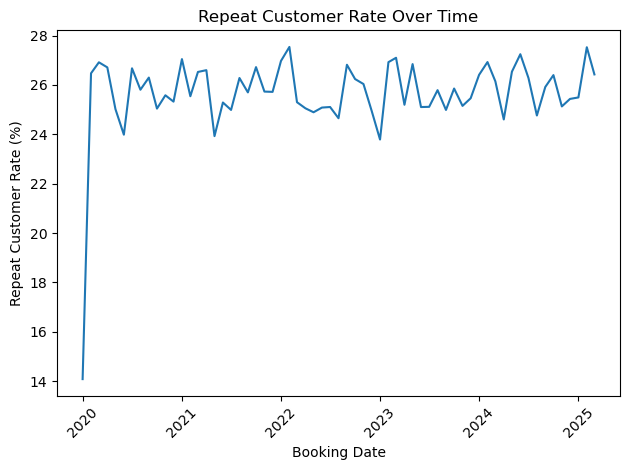

In [102]:
# Convert booking_date from Period[M] to Timestamp
repeat_customer_rate['booking_date'] = repeat_customer_rate['booking_date'].dt.to_timestamp()

sns.lineplot(data=repeat_customer_rate, x='booking_date', y='repeat_customer_rate')
plt.xlabel('Booking Date')
plt.ylabel('Repeat Customer Rate (%)')
plt.title('Repeat Customer Rate Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()